In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df = pd.read_csv("spotify.csv") 
df.head()

print(df.shape)
print(df.isna().sum())
df.describe(include="all").T



(10000, 10)
track_name           0
artist               0
genre                0
playlist_category    0
danceability         0
energy               0
valence              0
tempo                0
duration_ms          0
popularity           0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
track_name,10000,809,Night Light,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artist,10000,500,Artist_129,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genre,10000,9,Pop,1182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
playlist_category,10000,7,Sleep,1467,NaN,NaN,NaN,NaN,NaN,NaN,NaN
danceability,10000.0,NaN,NaN,NaN,0.494157,0.287634,0.0,0.246,0.493,0.74,1.0
energy,10000.0,NaN,NaN,NaN,0.504532,0.289291,0.0,0.254,0.506,0.756,1.0
valence,10000.0,NaN,NaN,NaN,0.500051,0.286779,0.0,0.254,0.502,0.745,1.0
tempo,10000.0,NaN,NaN,NaN,129.819853,40.459244,60.0,94.5575,130.005,164.6,199.97
duration_ms,10000.0,NaN,NaN,NaN,210726.7033,86588.246585,60019.0,135233.75,209934.0,286301.25,359994.0
popularity,10000.0,NaN,NaN,NaN,50.2352,28.623141,1.0,25.0,50.0,75.0,99.0


In [4]:
features = [
    "danceability",
    "energy",
    "valence",
    "tempo",
    "duration_ms",
    "popularity"
]

X = df[features].copy()
X.head()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]


array([[-0.41428649, -0.45123702,  0.80187189,  0.48248857,  1.37648308,
         1.35438449],
       [ 1.58835722, -0.59297   , -1.0986381 , -0.13643678,  1.48845537,
         1.42426152],
       [ 0.8269354 , -1.13570361, -0.53371586,  1.61182961, -0.92475261,
         1.28450746],
       [ 0.3645194 ,  0.35422114,  0.56823121, -0.96793234, -1.39038181,
         0.72549125],
       [-1.17570831, -0.09517612, -0.06294733,  0.30847761,  0.26755889,
        -0.07809457]])

In [5]:
scores = {}
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    scores[k] = silhouette_score(X_scaled, labels)

scores


{2: 0.12414372426769874,
 3: 0.11194636400216951,
 4: 0.11687862360001201,
 5: 0.1185794175080648,
 6: 0.12181782708622615,
 7: 0.1244559850720361,
 8: 0.12485707644677436,
 9: 0.12796166977051043,
 10: 0.13299083574479983}

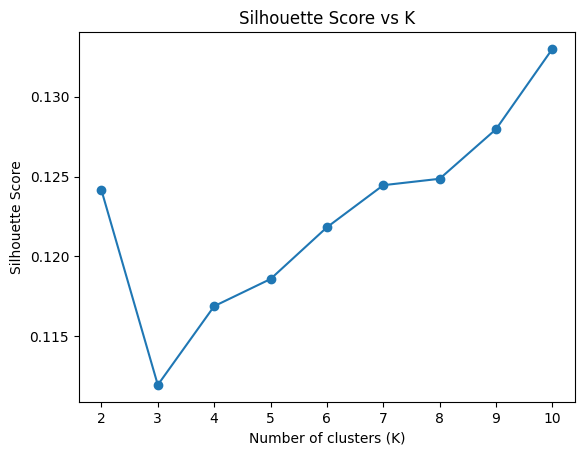

(10, 0.13299083574479983)

In [6]:
plt.figure()
plt.plot(list(scores.keys()), list(scores.values()), marker="o")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.show()

best_k = max(scores, key=scores.get)
best_k, scores[best_k]


In [7]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

df[["track_name", "artist", "genre", "playlist_category", "cluster"]].head()


,track_name,artist,genre,playlist_category,cluster
0,Love Sky,Artist_464,Classical,Chill,4
1,Fire Dream,Artist_221,Bollywood,Romantic,3
2,Light Night,Artist_357,Jazz,Sleep,5
3,Love Wave Night,Artist_389,Pop,Workout,0
4,Fire Light,Artist_451,EDM,Workout,4


In [10]:
cluster_summary = df.groupby("cluster")[features].mean()
print(cluster_summary)


         danceability    energy   valence       tempo    duration_ms  \
cluster                                                                
0            0.430767  0.742971  0.664826   98.560211  138340.474320   
1            0.611546  0.284214  0.243383  100.213836  177183.790338   
2            0.611986  0.277474  0.321476  158.292380  282078.057609   
3            0.688838  0.758081  0.356582  149.233957  275180.661622   
4            0.208502  0.392532  0.661524  153.007346  258130.400712   
5            0.758739  0.294575  0.753970  154.733834  171903.746220   
6            0.506151  0.732479  0.373152  162.419309  137784.586547   
7            0.629874  0.612326  0.749591  102.120302  272956.614515   
8            0.294292  0.248274  0.587565  120.050186  139003.511387   
9            0.242506  0.680637  0.259407   98.728729  262690.503205   

         popularity  
cluster              
0         71.091641  
1         69.252174  
2         27.119565  
3         74.400000  
4  

In [15]:

cluster_names = {}

for c in cluster_summary.index:
    energy = cluster_summary.loc[c, "energy"]
    valence = cluster_summary.loc[c, "valence"]
    dance = cluster_summary.loc[c, "danceability"]
    tempo = cluster_summary.loc[c, "tempo"]

    if energy < 0.4 and tempo < 120:
        cluster_names[c] = "Chill / Sleep"
    elif energy > 0.7 and dance > 0.6:
        cluster_names[c] = "Workout / Party"
    elif valence > 0.6 and energy > 0.5:
        cluster_names[c] = "Happy"
    elif valence < 0.4 and energy < 0.6:
        cluster_names[c] = "Emotional"
    else:
        cluster_names[c] = "Focus"

df["discovered_category"] = df["cluster"].map(cluster_names)

df[["track_name", "playlist_category", "discovered_category", "cluster"]].head()


,track_name,playlist_category,discovered_category,cluster
0,Love Sky,Chill,Focus,4
1,Fire Dream,Romantic,Workout / Party,3
2,Light Night,Sleep,Focus,5
3,Love Wave Night,Workout,Happy,0
4,Fire Light,Workout,Focus,4


In [16]:
comparison = pd.crosstab(df["playlist_category"], df["discovered_category"])
comparison
#This shows where your clustering matches Spotify labels.

discovered_category,Chill / Sleep,Emotional,Focus,Happy,Workout / Party
playlist_category,,,,,
Chill,133,144,712,266,146
Focus,155,147,692,301,134
Party,175,135,702,285,126
Romantic,137,122,731,316,131
Sleep,165,126,737,299,140
Travel,152,126,714,293,136
Workout,118,120,778,294,112


In [17]:
from sklearn.metrics.pairwise import cosine_similarity
# Cosine similarity between all songs (based on scaled features)
sim_matrix = cosine_similarity(X_scaled)

def recommend_similar_songs(track_name, top_n=5):
    # find index of the track
    matches = df.index[df["track_name"].str.lower() == track_name.lower()].tolist()
    if not matches:
        return f"Track '{track_name}' not found."

    idx = matches[0]
    similarity_scores = sim_matrix[idx]

    # get indices of most similar songs (excluding itself)
    similar_indices = np.argsort(similarity_scores)[::-1][1:top_n+1]

    return df.loc[similar_indices, ["track_name", "artist", "genre", "playlist_category", "discovered_category"]]


In [18]:
recommend_similar_songs("Fire Beat", top_n=5)


,track_name,artist,genre,playlist_category,discovered_category
8249,Light Dream Sky,Artist_127,Jazz,Travel,Emotional
3831,Love Heart,Artist_51,Jazz,Workout,Emotional
5071,Night Dance,Artist_235,Hip-Hop,Chill,Emotional
1510,Beat Sky Light,Artist_343,Classical,Sleep,Emotional
6823,Sky Heart Night,Artist_108,Jazz,Sleep,Emotional
